Hola **Christian**!

Soy **Patricio Requena** 👋. Es un placer ser el revisor de tu proyecto el día de hoy!

Revisaré tu proyecto detenidamente con el objetivo de ayudarte a mejorar y perfeccionar tus habilidades. Durante mi revisión, identificaré áreas donde puedas hacer mejoras en tu código, señalando específicamente qué y cómo podrías ajustar para optimizar el rendimiento y la claridad de tu proyecto. Además, es importante para mí destacar los aspectos que has manejado excepcionalmente bien. Reconocer tus fortalezas te ayudará a entender qué técnicas y métodos están funcionando a tu favor y cómo puedes aplicarlos en futuras tareas. 

_**Recuerda que al final de este notebook encontrarás un comentario general de mi parte**_, empecemos!

Encontrarás mis comentarios dentro de cajas verdes, amarillas o rojas, ⚠️ **por favor, no muevas, modifiques o borres mis comentarios** ⚠️:


<div class="alert alert-block alert-success">
<b>Comentario del revisor</b> <a class=“tocSkip”></a>
Si todo está perfecto.
</div>

<div class="alert alert-block alert-warning">
<b>Comentario del revisor</b> <a class=“tocSkip”></a>
Si tu código está bien pero se puede mejorar o hay algún detalle que le hace falta.
</div>

<div class="alert alert-block alert-danger">
<b>Comentario del revisor</b> <a class=“tocSkip”></a>
Si de pronto hace falta algo o existe algún problema con tu código o conclusiones.
</div>

Puedes responderme de esta forma:
<div class="alert alert-block alert-info">
<b>Respuesta del estudiante</b> <a class=“tocSkip”></a>


In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix

In [12]:
df = pd.read_csv("/datasets/Churn.csv")

In [13]:
df = df.drop(["RowNumber", "CustomerId", "Surname"], axis=1)

In [14]:
#aqui se detectaron un total de 909 datos nulos en la columna "Tenue" voy a rellenar esos valores con la mediana ya que no puedo simplemente eliminarlos porque son muchos
df['Tenure'] = df['Tenure'].fillna(df['Tenure'].median())

<div class="alert alert-block alert-danger">
<b>Comentario del revisor (1ra Iteracion)</b> <a class=“tocSkip”></a>

Hace falta la revisión del balance de clases en tu variable objetivo, en proyectos de clasificación este es un paso importante ya que de eso depende las técnicas a aplicar para el entrenamiento
</div>

In [15]:
df = pd.get_dummies(df, drop_first=True)

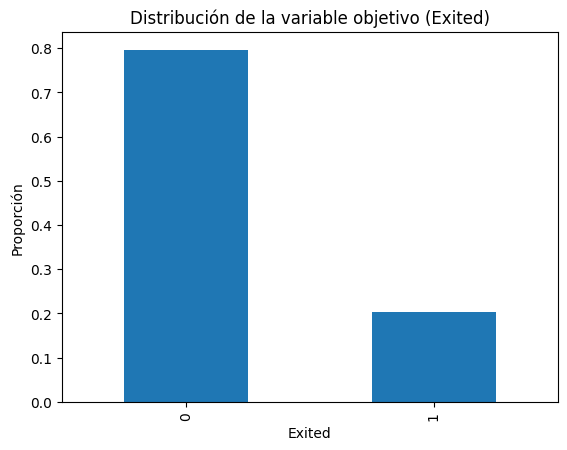

In [16]:
X = df.drop("Exited", axis=1)
y = df["Exited"]

y.value_counts(normalize=True).plot(kind="bar")
plt.title("Distribución de la variable objetivo (Exited)")
plt.xlabel("Exited")
plt.ylabel("Proporción")
plt.show()


In [17]:
# Dividir en train+valid y test
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Dividir train en train y valid
X_train, X_valid, y_train, y_valid = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

<div class="alert alert-block alert-success">
<b>Comentario del revisor (1ra Iteracion)</b> <a class=“tocSkip”></a>

Bien, ahora tienes los datos listos para el entrenamiento y evaluación de manera adecuada
</div>

In [18]:
log_reg = LogisticRegression(random_state=42, max_iter=500)
log_reg.fit(X_train_scaled, y_train)
y_pred_log = log_reg.predict(X_valid_scaled)
print("Logistic Regression F1:", f1_score(y_valid, y_pred_log))

rf = RandomForestClassifier(random_state=42, n_estimators=100)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_valid)
print("Random Forest F1:", f1_score(y_valid, y_pred_rf))

Logistic Regression F1: 0.3189964157706094
Random Forest F1: 0.5960061443932412


In [19]:
rf_bal = RandomForestClassifier(random_state=42, n_estimators=200, class_weight="balanced")
rf_bal.fit(X_train, y_train)
y_pred_rf_bal = rf_bal.predict(X_valid)
print("Balanced Random Forest F1:", f1_score(y_valid, y_pred_rf_bal))

Balanced Random Forest F1: 0.5507246376811594


In [22]:
y_proba = rf_bal.predict_proba(X_valid)[:, 1]

best_f1 = 0
best_threshold = 0

for thr in np.arange(0.1, 0.9, 0.01):
    y_pred_thr = (y_proba >= thr).astype(int)
    score = f1_score(y_valid, y_pred_thr)
    if score > best_f1:
        best_f1 = score
        best_threshold = thr

print(f"Mejor umbral: {best_threshold:.2f} con F1: {best_f1:.3f}")

Mejor umbral: 0.28 con F1: 0.632


In [23]:
y_proba_test = rf_bal.predict_proba(X_test)[:, 1]
y_pred_test = (y_proba_test >= best_threshold).astype(int)

print("Final F1 en Test:", f1_score(y_test, y_pred_test))
print("AUC-ROC en Test:", roc_auc_score(y_test, y_proba_test))
print("Matriz de confusión:\n", confusion_matrix(y_test, y_pred_test))

Final F1 en Test: 0.6072234762979684
AUC-ROC en Test: 0.8565692040268312
Matriz de confusión:
 [[1383  210]
 [ 138  269]]


Se inicio con LogisticRegression y RandomForest como modelos base para empezar.
RandomForest sin balanceo obtuvo F1= 0.596 
LogisticRegression sin balanceo quedo F1=0.319 (Random Forest nos servira mejor para este modelo)
Se utilizo class_weight='Balance' para optimizar el umbral de clasificacion logrando un F1 de 0.632 y en prueba final de 0.607 supernado el umbral minimo de 0.59
AUC-ROC quedo en 0.857, lo que significa que el modelo distingue que clientes se van y los que se podrian ir
en la matriz de confusion tenemos mas VN y BP que FP y FN lo cual es bueno y demuestra que esta teniendo mas aciertos que errores
Con esto podemos ver que el modelo RandomForest con balanceo de clases y ajuste de umbral es el mejor para predecir si un cliente del blanco se va o se queda

<div class="alert alert-block alert-warning">
<b>Comentario general (1ra Iteracion)</b> <a class=“tocSkip”></a>

Buen avance Christian! Sólo hay un par de cosas a corregir, la primera realacionada al balance de las clases que es un paso importante en todos tus proyectos de clasificación y la otra que no es un bloqueante para la aprobación pero no es una buena práctica es el utilizar celdas tipo código para redactar tus conclusiones o interpretaciones. 

Para comentarios extensos deberías utilizar celdas tipo Markdown cómo esta en la que dejo los comentarios de la revisión. Saludos!
</div>

<div class="alert alert-block alert-success">
<b>Comentario del revisor (2da Iteracion)</b> <a class=“tocSkip”></a>

Te felicito por el trabajo realizado Christian, se nota que conoces las métricas de evaluación y planteas conclusiones muy acertadas en cuanto a los resultados. Es importante siempre en un problema de ML identificar el balance entre las clases de tu variable objetivo para poder escoger la métrica correcta ya que para datasets desbalanceados la métrica de accuracy suele presentar buenos valores pero en realidad las predicciones no son buenas y es por la forma en cómo se calcula esta métrica que puede llevar a interpretaciones erroneas en cambio el f1-score es la ideal para este tipo de casos ya que maneja mejor este tipo de problemas.
    
Saludos!
</div>